<a href="https://colab.research.google.com/github/bongkyunSON/Quant_Factor/blob/main/%EC%A3%BC%EC%8B%9D_%EB%AA%A8%EB%A9%98%ED%85%80_%EC%A0%84%EB%9E%B5_%EA%B5%AC%ED%98%84_221226.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 패키지 설치
!pip install pickle5 --quiet

     |████████████████████████████████| 132 kB 5.0 MB/s 


In [2]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle5 as pickle
sns.set()

In [5]:
# 가격 데이터 로드
with open('equity_price.pkl', 'rb') as f:
    price = pickle.load(f)

In [6]:
price

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2010-01-04,7.643,57.715,40.92,56.18,58.55,18.7050,24.69,79.06,32.07,NaN,...,35.2900,30.950,16.3375,61.12,49.81,31.53,22.0350,31.0965,37.30,54.23
2010-01-05,7.656,57.220,40.83,58.02,59.25,18.6250,24.58,79.62,31.99,NaN,...,35.4330,30.960,16.4025,61.14,48.63,31.48,21.7825,31.1526,37.00,53.69
2010-01-06,7.535,56.790,41.49,59.78,59.43,18.5925,24.42,79.63,31.82,NaN,...,35.9098,30.770,16.3025,60.85,47.94,31.79,21.4900,29.8257,36.72,53.57
2010-01-07,7.521,56.270,41.98,62.20,59.67,18.5100,24.53,79.33,31.83,NaN,...,35.9670,30.452,16.4625,60.52,48.63,33.01,21.6900,29.6482,36.94,53.60
2010-01-08,7.571,56.770,41.95,61.60,60.34,18.5375,24.66,79.47,31.88,NaN,...,35.9479,30.660,16.4300,60.44,48.56,32.70,21.7500,29.6669,36.99,53.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,138.980,245.440,137.35,131.57,179.75,142.5700,39.58,157.17,93.10,43.95,...,91.0500,225.410,87.9900,124.23,159.46,499.81,179.1400,35.9400,32.61,132.67
2022-10-12,138.340,246.440,136.74,130.42,179.50,142.2900,39.27,157.64,93.41,43.81,...,90.4200,225.750,88.5100,124.43,159.16,499.96,178.2400,35.6800,31.94,131.17
2022-10-13,142.990,251.660,141.55,132.40,183.14,145.4400,40.61,165.28,96.64,45.92,...,92.4900,234.240,89.5600,126.31,165.51,509.91,184.6600,36.4000,33.65,132.28
2022-10-14,138.380,251.340,136.81,133.15,178.19,142.2200,40.20,160.14,94.45,45.12,...,92.1800,228.560,87.5500,125.08,163.30,513.13,182.6200,36.3800,33.24,130.43


In [7]:
# 주식 모멘텀 클래스
class EquityMomentum:

    # 초기화 함수
    def __init__(self, price, lookback_period, n_selection, cost=0.0005, signal_method='dm', long_only=False):

        # 수익률
        self.rets = price.pct_change().fillna(0)

        # 모멘텀 방식 선택
        if signal_method == 'am':
            self.signal = self.absolute_momentum(price, lookback_period, long_only)
        elif signal_method == 'rm':
            self.signal = self.relative_momentum(price, lookback_period, n_selection, long_only)
        elif signal_method == 'dm':
            self.signal = self.dual_momentum(price, lookback_period, n_selection, long_only)

        # 거래비용
        self.cost = cost
        
        # 포트폴리오 수익률
        self.port_rets = self.calculate_returns(self.rets, self.signal, self.cost)

        # 샤프비율
        self.sharpe_ratio = self.calculate_sharpe_ratio(self.port_rets)

        # 백테스팅 결과
        self.plot_result(self.port_rets)

    # 절대 모멘텀 시그널 계산 함수
    def absolute_momentum(self, price, lookback, long_only=False):

        # N일 수익률  
        returns = price.pct_change(periods=lookback)

        # 롱 시그널
        long_signal = (returns > 0) * 1

        # 숏 시그널
        short_signal = (returns < 0) * -1

        # 토탈 시그널
        if long_only:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        
        return signal
    
    # 상대 모멘텀 시그널 계산 함수
    def relative_momentum(self, price, lookback, n_selection, long_only=False):

        # N일 수익률
        returns = price.pct_change(periods=lookback)

        # 수익률 순위화
        rank = returns.rank(axis=1, ascending=False)

        # 롱 시그널
        long_signal = (rank <= n_selection) * 1

        # 숏 시그널
        short_signal = (rank >= len(rank.columns) - n_selection + 1) * -1

        # 토탈 시그널
        if long_only:
            signal = long_signal
        else:
            signal = long_signal + short_signal

        return signal
    
    # 듀얼 모멘텀 시그널 계산 함수
    def dual_momentum(self, price, lookback, n_selection, long_only=False):

        # 절대 모멘텀 시그널
        abs_signal = self.absolute_momentum(price, lookback, long_only)

        # 상대 모멘텀 시그널
        rel_signal = self.relative_momentum(price, lookback, n_selection, long_only)

        # 듀얼 모멘텀 시그널
        signal = (abs_signal == rel_signal) * abs_signal

        return signal

    # 포트폴리오 수익률 계산 함수
    def calculate_returns(self, rets, signals, cost):

        # 포트폴리오 수익률
        port_rets = signals.shift() * rets - abs(signals.diff()) * cost

        return port_rets.mean(axis=1)

    # 샤프비율 계산
    def calculate_sharpe_ratio(self, total_returns):
        sharpe_ratio = total_returns.mean() * np.sqrt(252) / total_returns.std()

        return sharpe_ratio

    # 백테스팅 결과 시각화 함수
    def plot_result(self, rets):

        # 백테스팅 결과 시각화
        plt.figure(figsize=(12, 6))
        rets.cumsum().plot()
        plt.show()

### 패러미터 세팅

In [8]:
# 룩백 윈도우
lookback = 20 * 24

# 상대 모멘텀 롱숏 개수
n_selection = len(price.columns) / 4

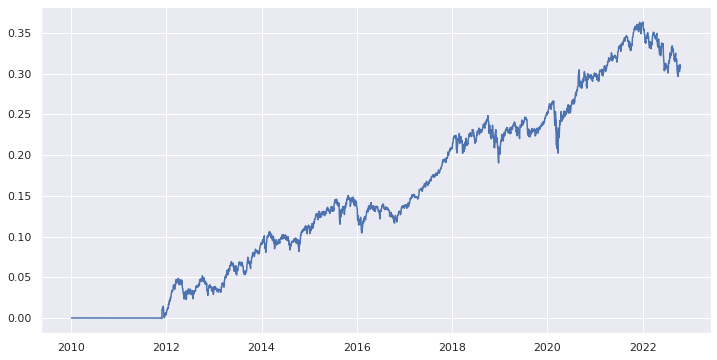

In [9]:
# 주식 모멘텀 백테스팅
momentum = EquityMomentum(price, lookback, n_selection, long_only=True)

In [10]:
momentum.sharpe_ratio

0.6105391498187076

Copyright 2022. 퀀트대디. All rights reserved.